***
***

# Diffusion Profiles - Experiment 1
***

**Authors:** [TJCallahan](https://mail.google.com/mail/u/0/?view=cm&fs=1&tf=1&to=callahantiff@gmail.com)

**Associated Resources:**   
- [PheKnowLator](https://github.com/callahantiff/multiscale-interactome/tree/development)  
- [Planned Experiments](https://docs.google.com/document/d/1wjEgJK3wkHB-h_fIIg5mM2JtVJ7ts9alrHIKTOklb_Q/edit#)  
- [Validation Data](https://docs.google.com/spreadsheets/d/1Uw-50AAhYS7GCz_7EsKHD8nUsiqTjJCuKQvfaqzaEqw/edit#gid=1173356993)
  
<br>  
  
### Notebook Objective   
***
This notebook is designed to document the experiments performed on the the Diffusion Profile library, originally developed at Stanford University. The objective of this experiment is to explore different ways of leveraging the diffusion profiles with the goal of determining how well they do at recovering known negative controls and side effects from the OHDSI Legacy Hypertension Study and the literature. For these experiments, we will focus on `lisinopril` and `coughing`, using the different ways to examine a graph to determine whether or not we find entities that we know we should and don't find things that we know we shouldn't. More details are provided in the *Case Study* section of this notebook.

<br>

#### Created Data Structures  
The following structures were created and analyzed for the experiments in this notebook:  
- *Diffusion Profiles*
  - `results/msi_diffusion_profile_matrix.npy`  
  - `results/msi_diffusion_profile_matrix_adjusted.npy`
- *Mulitscale Interactome Graph*  
  - `results/msi_diffusion_profile_matrix_index_ids.npy`  
  - `results/msi_diffusion_profile_matrix_index_ids.npy`  
  - `results/msi_graph_node2name.pkl`
  - `results/msi_graph_node2type.pkl`  
  - `results/msi_graph.pkl`  

<br>

#### Validation Data
All concepts referenced below will be mapped to `UMLS` concepts so their identifiers are compatible with the disease identifiers used in the graph.
- Negative Controls (filtered for Hypertension) → [here](https://github.com/OHDSI/Legend/blob/master/inst/settings/NegativeControls.csv)
  - Spreadsheet Tab: `lisinopril_negative_controls` ([here](https://docs.google.com/spreadsheets/d/1Uw-50AAhYS7GCz_7EsKHD8nUsiqTjJCuKQvfaqzaEqw/edit?usp=sharing))
- Known side effects (shown below, from Mayo clinic [here](https://www.mayoclinic.org/drugs-supplements/lisinopril-oral-route/side-effects/drg-20069129?p=1) and at UpToDate [here](https://www.uptodate.com/contents/major-side-effects-of-angiotensin-converting-enzyme-inhibitors-and-angiotensin-ii-receptor-blockers#H939716))
  - Spreadsheet Tab: `lisinopril_known_side_effects` ([here](https://docs.google.com/spreadsheets/d/1Uw-50AAhYS7GCz_7EsKHD8nUsiqTjJCuKQvfaqzaEqw/edit?usp=sharing))

<br>


### Notebook Organization   
***
* [Global Environment Set-Up](#set-up)  
* [Descriptive Statistics](#descriptive-stats)  
* [Case Study](#case-study)  
  * [Network Topology](#network-topology)  
  * [Diffusion Profiles](#diffusion-profiles)

<br>  


***
***

<br>

***  
***

## Global Environment Set-Up  <a class="anchor" id="set-up"></a>
This section helps set-up the coding environment by loading needed Python libraries and applies global settings for plotting. This section also includes code to load the data structures that will be analyzed. Please see the [`main.py`](https://github.com/callahantiff/multiscale-interactome/blob/master/main.py) file in the `multiscale-interactome` GitHub for more information on the code that was used to create the data structures.


In [183]:
# import and load needed scripts
import matplotlib.patches as mp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from utilities import *

# plot settings
%matplotlib inline
plt.style.use('ggplot')

In [146]:
# read in needed data
dp_matrix = np.load("../results/msi_diffusion_profile_matrix.npy")
# dp_matrix_adj = np.load("../results/msi_diffusion_profile_matrix_adjusted.npy")
node_idx_dict = pickle.load(open("../results/msi_diffusion_profile_matrix_index_ids.npy", "rb"))
node_labels = pickle.load(open("../results/msi_graph_node2name.pkl", "rb"))
node_types = pickle.load(open("../results/msi_graph_node2type.pkl", "rb"))
# msi_graph = pickle.load(open("../results/msi_graph.pkl", "rb"))

In [139]:
del dp_matrix_adj

<br>

***  
***

## Descriptive Statistics  <a class="anchor" id="descriptive-stats"></a>
This section presents the results from calculating statistics on the MSI graph and the diffusion profiles. A list of the analyses that were performed is provided below.
- [Graph Overview](#graph-overview)  
- [Degree](#degree)  
- [Diffusion Profiles Importance](#importance)  
- [Diffusion Profile Cosine similarity](#cosine-similarity)   
  

#### Graph Overview  <a class="anchor" id="graph-overview"></a>

In [15]:
print('The graph has {} edges'.format(len(msi_graph.edges())))

The graph has 957050 edges


In [11]:
# get counts of edges by edge type
keys = [['drug', 'protein'], ['indication', 'protein'], ['protein', 'protein'],
        ['protein', 'biological_function'], ['biological_function', 'biological_function']]
for k1, k2 in keys:
    cnt1, cnt2 = set(), set()
    for i, j in msi_graph.edges():
        if k1 in node_types[i] and k2 in node_types[j]:
            cnt1 |= {'{}-{}'.format(i, j)}
    print('EDGE TYPE: {} - {}: {} edges'.format(k1, k2, str(len(cnt1))))


EDGE TYPE: drug - protein: 8568 edges
EDGE TYPE: indication - protein: 25212 edges
EDGE TYPE: protein - protein: 774846 edges
EDGE TYPE: protein - biological_function: 34777 edges
EDGE TYPE: biological_function - biological_function: 45090 edges


In [12]:
print('The graph has {} nodes'.format(len(msi_graph.nodes())))

The graph has 29902 nodes


In [14]:
# get counts of nodes by node type
cnt = set()
keys = ['drug', 'indication', 'protein', 'biological_function']
for k in keys:
    cnt = set()
    for i, j in msi_graph.edges():
        if k in node_types[i]:
            cnt |= {i}
    print('NODE TYPE: {}: {} edges'.format(k, str(len(cnt))))

NODE TYPE: drug: 1661 edges
NODE TYPE: indication: 840 edges
NODE TYPE: protein: 17603 edges
NODE TYPE: biological_function: 9798 edges


#### Degree  <a class="anchor" id="degree"></a>

In [16]:
degree_list = [x[1] for x in list(msi_graph.degree())]
print(gets_simple_statistics(degree_list, "msi graph", "degree"))

Statistics (msi graph, degree): min=2; max=4600; median=18.0; mean=64.012


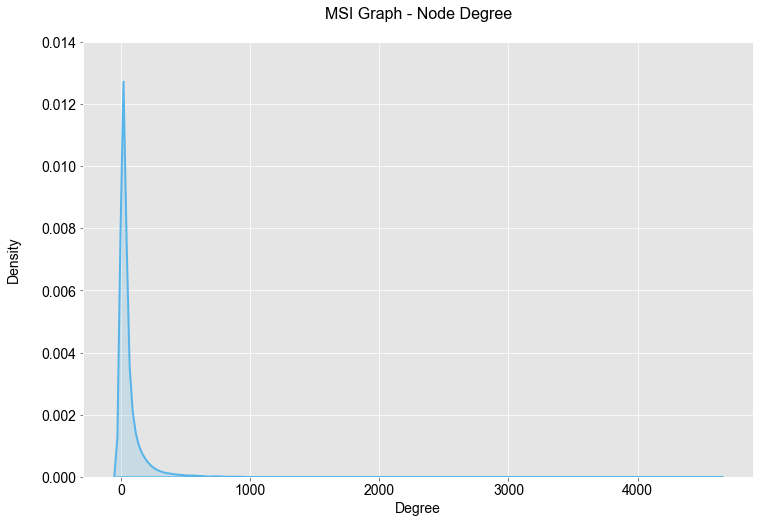

In [17]:
# create histogram
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
y = sns.kdeplot(degree_list, color='#56B4E9', label='Degree', shade=True, linewidth=2, alpha=0.2)
plt.title('MSI Graph - Node Degree\n', fontsize=16, fontname="Arial", color='black')
plt.suptitle('')
plt.xlabel('Degree', fontsize=14, fontname="Arial", color='black')
plt.ylabel('Density\n', fontsize=14, fontname="Arial", color='black')
plt.ylim(0.0, 0.014)
plt.tick_params(labelsize=14)
plt.yticks(color='black', fontname="Arial", fontsize=14)
plt.xticks(color='black', fontname="Arial", fontsize=14)
plt.show()

#### Diffusion Profile Importance  <a class="anchor" id="importance"></a>

*Including Self-Importance*

In [47]:
min_imp = dp_matrix.min(1)
max_imp = dp_matrix.max(1)
mean_imp = dp_matrix.mean(1)
median_imp = [np.median(x) for x in tqdm(dp_matrix)]

100%|██████████| 29902/29902 [00:11<00:00, 2533.05it/s]


In [48]:
print_str = 'Statistics: min={}; max={}; median={}; mean={}'
f_str = print_str.format(min(min_imp), max(max_imp), np.median(median_imp), np.mean(mean_imp))
print(f_str)

Statistics: min=2.845084216098717e-10; max=0.40964309812424; median=4.446121634437144e-06; mean=3.3442579091699556e-05


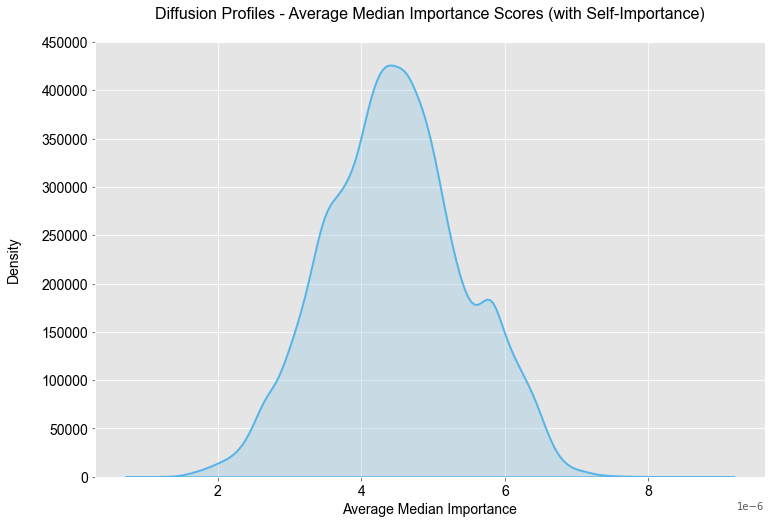

In [49]:
# create histogram
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
y = sns.kdeplot(median_imp, color='#56B4E9', label='Average Median Importance', shade=True, linewidth=2, alpha=0.2)
plt.title('Diffusion Profiles - Average Median Importance Scores (with Self-Importance)\n', fontsize=16, fontname="Arial", color='black')
plt.suptitle('')
plt.xlabel('Average Median Importance', fontsize=14, fontname="Arial", color='black')
plt.ylabel('Density\n', fontsize=14, fontname="Arial", color='black')
plt.ylim(0.0, 450000)
plt.tick_params(labelsize=14)
plt.yticks(color='black', fontname="Arial", fontsize=14)
plt.xticks(color='black', fontname="Arial", fontsize=14)
plt.show()

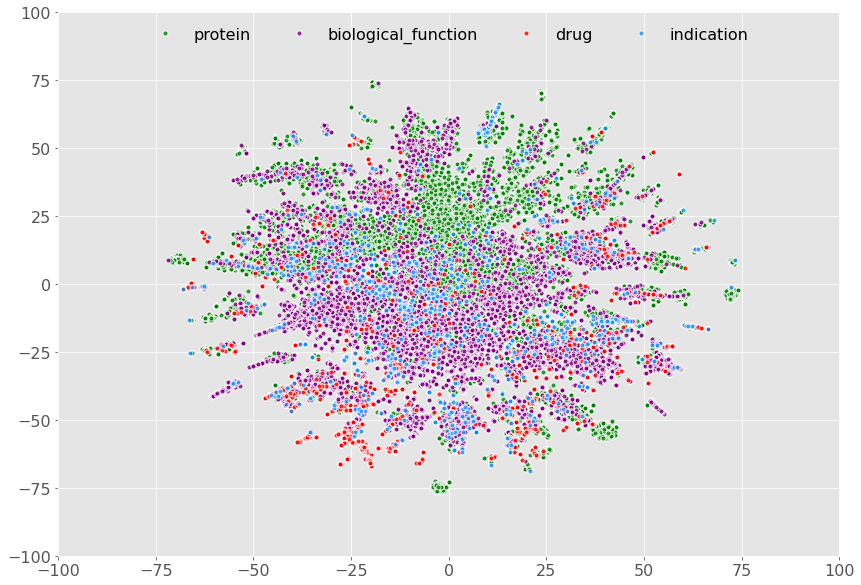

In [25]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix)
X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)

ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

*Excluding Self-Importance*

In [41]:
min_imp = dp_matrix_adj.min(1)
max_imp = dp_matrix_adj.max(1)
mean_imp = dp_matrix_adj.mean(1)
median_imp = [np.median(x) for x in tqdm(dp_matrix_adj)]

100%|██████████| 29902/29902 [00:11<00:00, 2620.75it/s]


In [42]:
print_str = 'Statistics: min={}; max={}; median={}; mean={}'
f_str = print_str.format(min(min_imp), max(max_imp), np.median(median_imp), np.mean(mean_imp))
print(f_str)

Statistics: min=2.845084216098717e-10; max=0.3117204112195686; median=4.4458779977617805e-06; mean=2.6313434941590553e-05


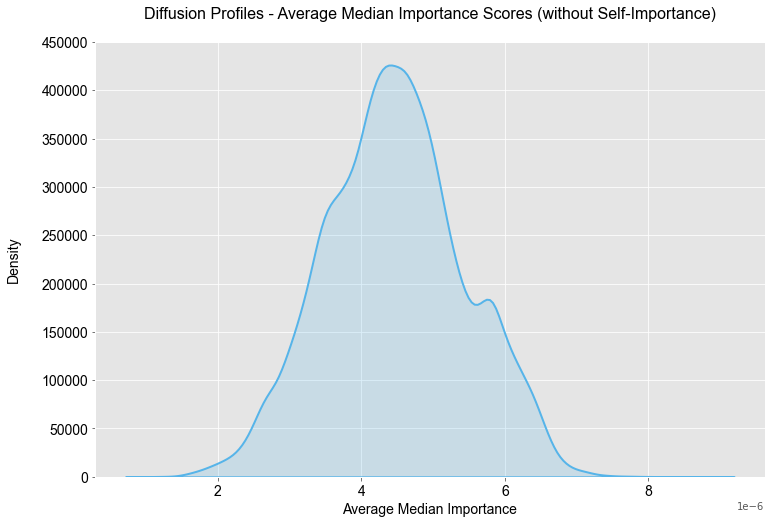

In [45]:
# create histogram
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
y = sns.kdeplot(median_imp, color='#56B4E9', label='Average Median Importance', shade=True, linewidth=2, alpha=0.2)
plt.title('Diffusion Profiles - Average Median Importance Scores (without Self-Importance)\n', fontsize=16, fontname="Arial", color='black')
plt.suptitle('')
plt.xlabel('Average Median Importance', fontsize=14, fontname="Arial", color='black')
plt.ylabel('Density\n', fontsize=14, fontname="Arial", color='black')
plt.ylim(0.0, 450000)
plt.tick_params(labelsize=14)
plt.yticks(color='black', fontname="Arial", fontsize=14)
plt.xticks(color='black', fontname="Arial", fontsize=14)
plt.show()

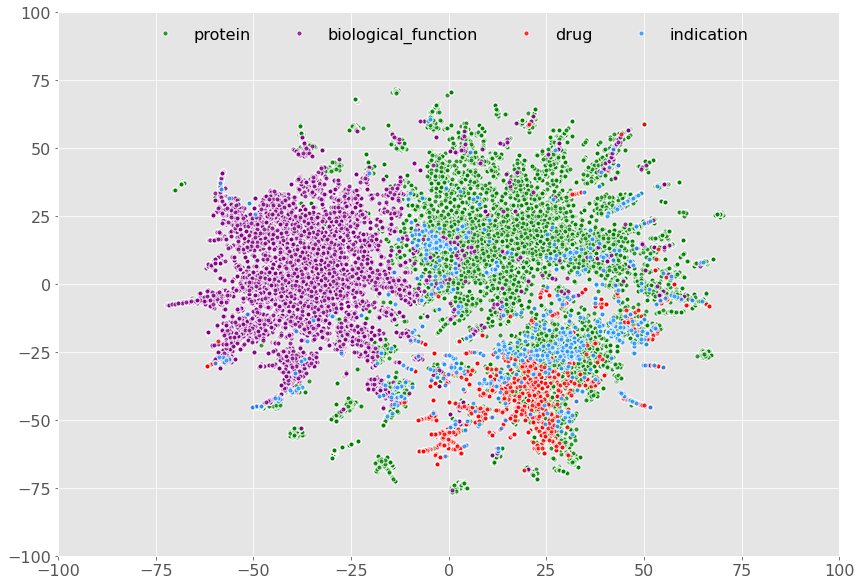

In [29]:
# t-sne plot of diffusion profiles
# reduce dimensionality of diffusion profiles for plotting
# X_reduced = TruncatedSVD(n_components=50, random_state=1).fit_transform(dp_matrix_adj)
# X_embedded = TSNE(n_components=2, random_state=1, verbose=True, perplexity=50.0).fit_transform(X_reduced)

# create data frame that has decomposed diffusion profiles and the node type
label_type = [node_types[node_idx_dict[x]] for x in range(0, len(node_idx_dict.keys()))]
df = pd.DataFrame(dict(x=X_embedded[:, 0], y=X_embedded[:, 1], group=label_type))
groups = df.groupby('group')
colors = {'drug': 'red', 'indication': 'dodgerblue', 'protein': 'green', 'biological_function': 'purple'}

# create t-SNE plots
fig, ax = plt.subplots(figsize=(14, 10))
ax.margins(0.05)  # adding 5% padding to the autoscaling
for name, group in groups:
    if name == 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)
for name, group in groups:
    if name != 'protein':
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, label=name,
                color=colors[name], mec='white', alpha=0.8)

ax.tick_params(labelsize=16)
ax.legend(numpoints=1, fontsize=16, frameon=False, loc="upper center", ncol=4)
plt.ylim(-100, 100)
plt.xlim(-100, 100)
plt.show()

#### Cosine Similarity  <a class="anchor" id="cosine-similarity"></a>

*Including Self-Importance*

In [ ]:
# takes a VERY long time to run
# co_sim_res = []
# for i in tqdm(node_idx_dict.keys()):
#     index_sim = dp_matrix[i]
#     co_sim = [dot(index_sim, dp_matrix[x])/(norm(index_sim)*norm(dp_matrix[x]))
#               for x in range(0, len(dp_matrix)) if x != i]
#     res = [min(co_sim), max(co_sim), np.median(co_sim), np.mean(co_sim)]
#     co_sim_res.append(res)

In [25]:
# all pairwise cosine similarity scores (takes ~40 min)
cosine_sim = cosine_similarity(dp_matrix, dp_matrix).flatten()

In [26]:
print(gets_simple_statistics(cosine_sim, "dp_matrix", "cosine similarity"))

Statistics (dp_matrix, cosine similarity): min=4.530673582887852e-05; max=1.0000000000000295; median=0.002; mean=0.003


*Excluding Self-Importance*

In [ ]:
# takes a VERY long time to run
# co_sim_res = []
# for i in tqdm(node_idx_dict.keys()):
#     index_sim = dp_matrix_adj[i]
#     co_sim = [dot(index_sim, dp_matrix_adj[x])/(norm(index_sim)*norm(dp_matrix_adj[x]))
#               for x in range(0, len(dp_matrix)) if x != i]
#     res = [min(co_sim), max(co_sim), np.median(co_sim), np.mean(co_sim)]
#     co_sim_res.append(res)

In [30]:
# all pairwise cosine similarity scores (takes ~40 min)
cosine_sim_adj = cosine_similarity(dp_matrix_adj, dp_matrix_adj).flatten()

In [31]:
print(gets_simple_statistics(cosine_sim_adj, "dp_matrix_adj", "cosine similarity"))

Statistics (dp_matrix_adj, cosine similarity): min=6.301928269802017e-05; max=1.0000000000000282; median=0.01; mean=0.019


<br><br>

***
***

## Case Study  <a class="anchor" id="case-study"></a>
This section will examine the value of the diffusion profiles and compare them to using traditional network science =-based measure of topology. As an illustration, we will compare the value of each of these different approaches when applied to **lisinopril** (`DrugBank:DB00722`) and **coughing** (`UMLS:C0010200`).

In [36]:
# lisinopril (DB00722)
lisinopril_concept_id = [k for k, v in node_labels.items() if v.lower() == "lisinopril"][0]
lisinopril_index = [k for k, v in node_idx_dict.items() if v == lisinopril_concept_id][0]

# cough (C0010200)
cough_concept_id = [k for k, v in node_labels.items() if v.lower() == "coughing"][0]
cough_index = [k for k, v in node_idx_dict.items() if v == cough_concept_id][0]

<br>

***  
***

## Network Topology  <a class="anchor" id="network-topology"></a>
The goal of this section is to use network topology-based measures to determine the relationship between lisinopril and coughing.

**Topology Measures**
- <u>Shortest Paths</u>: Get all shortest paths that exist between two nodes (may need to treat graph as undirected)  
- <u> Simple Paths</u>: Get all paths of length $n$ that exist between two nodes without repeating any nodes in the path.
- <u>Efficency</u>: A measure of how efficiently information is exchanged between nodes, which ranges between 0-1

In [34]:
# create undirected version of graph
undirected_msi_graph = nx.to_undirected(msi_graph)

*Lisinopril's Neighborhood*

In [59]:
nodes_o = list(msi_graph.neighbors(lisinopril_concept_id))
out_neighbors = [[node_labels[lisinopril_concept_id], node_labels[n]] for n in nodes_o]
out_neighbors

[['lisinopril', 'ACE'], ['lisinopril', 'ACE2']]

*Coughing's Neighborhood*

In [62]:
nodes_o = list(msi_graph.neighbors(cough_concept_id))
out_neighbors = [[node_labels[cough_concept_id], node_labels[n]] for n in nodes_o]
out_neighbors

[['Coughing', 'CD79A'],
 ['Coughing', 'CD79B'],
 ['Coughing', 'CTLA4'],
 ['Coughing', 'ACE'],
 ['Coughing', 'GBA'],
 ['Coughing', 'HLA-DPB1'],
 ['Coughing', 'HLA-DRB1'],
 ['Coughing', 'IGHM'],
 ['Coughing', 'IGLL1'],
 ['Coughing', 'KNG1'],
 ['Coughing', 'MARS'],
 ['Coughing', 'PIK3R1'],
 ['Coughing', 'PRTN3'],
 ['Coughing', 'RNF6'],
 ['Coughing', 'STAT3'],
 ['Coughing', 'TCF3'],
 ['Coughing', 'TGFBR2'],
 ['Coughing', 'TSC1'],
 ['Coughing', 'TSC2'],
 ['Coughing', 'DLEC1'],
 ['Coughing', 'PTPN22'],
 ['Coughing', 'BLNK'],
 ['Coughing', 'WWOX']]

**Shortest Paths**

In [65]:
# function to get shortest path between two nodes
s = lisinopril_concept_id; t = cough_concept_id
try:
    kg_orientation = msi_graph; ind = 'directed'
    spl_d = nx.shortest_path_length(msi_graph, source=s, target=t)  
    print('The shortest path length is: {} ({})'.format(str(spl_d), ind))
    # get efficiency (measure of how efficiently information is exchanged between nodes)
    eff = nx.efficiency(undirected_msi_graph, s, t)
    print('The efficiency between the nodes is: {}'.format(str(eff)))
except nx.NetworkXNoPath:
    print('There is no path between {} and {}'.format(str(s), str(t)))
    kg_orientation = undirected_msi_graph; ind = 'undirected'
    spl_d = nx.shortest_path_length(undirected_msi_graph, source=s, target=t)
    print('The shortest path length is: {} ({})'.format(str(spl_d), ind))

The shortest path length is: 2 (directed)
The efficiency between the nodes is: 0.5


In [66]:
shortest_paths1 = list(nx.all_shortest_paths(kg_orientation, s, t))
p_len = nx.shortest_path_length(kg_orientation, source=s, target=t)
v = 'is' if len(shortest_paths1) == 1 else 'are'
print('There {} {} shortest paths of length {}'.format(v, str(len(shortest_paths1)), str(p_len)))

There is 1 shortest paths of length 2


In [86]:
for path in shortest_paths1:
    print('*' * 100)
    for i in range(0, len(path) - 1):
        print('{}, {}'.format(node_labels[path[i]], node_labels[path[i + 1]]))
    print('*' * 100)

****************************************************************************************************
lisinopril, ACE
ACE, Coughing
****************************************************************************************************


**Simple Paths**

In [103]:
# simple paths (i.e., no repeated nodes)
simple_paths1 = []; counter = 0; simple_path_len = 3
for path in tqdm(nx.all_simple_paths(kg_orientation, source=s, target=t, cutoff=simple_path_len)):
    simple_paths1 += [path]
    if counter == 25: break
    else: counter += 1

# print results
v = 'is' if len(simple_paths1) == 1 else 'are'
print('There {} {} simplest paths of length {}'.format(v, str(len(simple_paths1)), str(simple_path_len)))

25it [00:00, 513.22it/s]

There are 26 simplest paths of length 3


In [104]:
for path in simple_paths1:
    print('*' * 100)
    for i in range(0, len(path) - 1):
        if i == 0:
            print('{}, {}'.format(node_labels[lisinopril_concept_id], node_labels[path[i]]))
            print('{}, {}'.format(node_labels[path[i]], node_labels[path[i + 1]]))
        else:
            print('{}, {}'.format(node_labels[path[i]], node_labels[path[i + 1]]))
    print('*' * 100)

****************************************************************************************************
lisinopril, ACE
ACE, Adenocarcinoma
Adenocarcinoma, STAT3
STAT3, Coughing
****************************************************************************************************
****************************************************************************************************
lisinopril, ACE
ACE, Alcoholic Intoxication, Chronic
Alcoholic Intoxication, Chronic, PIK3R1
PIK3R1, Coughing
****************************************************************************************************
****************************************************************************************************
lisinopril, ACE
ACE, Autistic Disorder
Autistic Disorder, HLA-DRB1
HLA-DRB1, Coughing
****************************************************************************************************
****************************************************************************************************
lisinopril, ACE
ACE, Au

<br>

***  
***

## Diffusion Profiles  <a class="anchor" id="diffusion-profiles"></a>
The goal of this section was to examine the utility of using diffusion profiles as a means for determining the relationship between two variables in the graph, in this case lisinopril and coughing. Unlike topology-based metrics, diffusion profiles do not require entities in the graph to physically connected. For all experiments in this notebook, two different types of scores that can be applied to the diffusion profiles are leveraged, each of which is defined and described within their respective sections below.

**Diffusion Profile Metrics**  
* [Importance](#importance)  
* [Cosine Similarity](#cosine-similarity)  



<br>

### Importance  <a class="anchor" id="importance"></a>  
This section examines the utility of diffusion profile importance (i.e., page rank). 

For a primary node, look within its diffusion profile array for its importance score to a specific node. Higher score = higher importance.
  - Importance scores are not symmetric; the importance of $node_j$ within $node_i$’s diffusion profile  the importance of $node_i$ within $node_j$’s diffusion profile.
  - Can take the average or median of the two scores to obtain a single importance score.

In [114]:
imp = get_node_pair_importance(dp_matrix, lisinopril_index, cough_index, 'lisinopril', 'coughing')
print('\n'.join(imp))

The importance of coughing within lisinopril's Diffusion Profile: 0.0005531529238047234
The importance of lisinopril within coughing's Diffusion Profile: 8.393128122828203e-05
The average importance of both node's Diffusion Profiles: 0.0003185421025165027


<br>

### Cosine Similarity  <a class="anchor" id="cosine-similarity"></a>
***
This section examines the utility of diffusion profile cosine similarity. It works by obtaining the diffusion profiles for each node, remove self-importance score, and then calculate cosine similarity between the profiles. Scores range 0-1; 0=different and 1=identical.

* [Task 1](#task1)  
* [Task 2](#task2)  

NEED TO DEFINE WHAT THE SCORE IS HERE AND ADD THE FORMULA
ADD TABLE CONTENTS

<br>

### Task 1  <a class="anchor" id="task1"></a>
This task will examine the following three different ways to obtain the cosine similarity score between `lisinopril` and `cough`:
  - Get cosine similarity score for $node_i$ and $node_j$
  - Cosine Similarity Rank
    - $node_i$ ranking within $node_j$’s sorted list of similar nodes
    - $node_j$ ranking within $node_i$’s sorted list of similar nodes

In [141]:
# extract each node's diffusion profile from matrix
# including self-importance
dp_imp_lisinopril = dp_matrix[lisinopril_index]
dp_imp_cough = dp_matrix[cough_index]

# # excluding self-importance
dp_imp_lisinopril_adj = dp_matrix_adj[lisinopril_index]
dp_imp_cough_adj = dp_matrix_adj[cough_index]

***Including Self-Importance***

In [121]:
co_sin = round(dot(dp_imp_lisinopril, dp_imp_cough)/(norm(dp_imp_lisinopril) * norm(dp_imp_cough)), 10)
print('The Cosine Similarity between {} and {} is: {}'.format('lisinopril', 'cough', co_sin))

The Cosine Similarity between lisinopril and cough is: 0.0186984424


In [151]:
# get the ranking of cough within lisinopril's sorted list of similar nodes
# get lisinoprils's cosine similarity
sim_res_lis = similarity_search(dp_matrix, lisinopril_index, len(node_idx_dict) - 1)

# get ranking information
cough_in_lis = [x for x in sim_res_lis if x[0] == cough_index]
cough_in_lis_position = sim_res_lis.index(cough_in_lis[0])
cough_in_lis_score = cough_in_lis[0][1]
str_print = "{} had a position of {} with score {} in Lisinopril's sorted list of similar nodes"
print(str_print.format('Cough', str(cough_in_lis_position), str(cough_in_lis_score)))

Cough had a position of 73 with score 0.018698442449844574 in Lisinopril's sorted list of similar nodes


In [152]:
# get the ranking of lisinopril within cough's sorted list of similar nodes
# get cough's cosine similarity
sim_res_cough = similarity_search(dp_matrix, cough_index, len(node_idx_dict) - 1)

# get ranking information
lis_in_cough = [x for x in sim_res_cough if x[0] == lisinopril_index]
lis_in_cough_position = sim_res_cough.index(lis_in_cough[0])
lis_in_cough_score = lis_in_cough[0][1]
str_print = "{} had a position of {} with score {} in Cough's sorted list of similar nodes"
print(str_print.format('Lisinopril', str(lis_in_cough_position), str(lis_in_cough_score)))

Lisinopril had a position of 77 with score 0.01869844244984458 in Cough's sorted list of similar nodes


***Excluding Self-Importance***

In [142]:
co_sin = round(dot(dp_imp_lisinopril_adj, dp_imp_cough_adj)/(norm(dp_imp_lisinopril_adj) * norm(dp_imp_cough_adj)), 10)
print('The Cosine Similarity between {} and {} is: {}'.format('lisinopril', 'cough', co_sin))


The Cosine Similarity between lisinopril and cough is: 0.1477960718


In [143]:
# get the ranking of cough within lisinopril's sorted list of similar nodes
# get lisinoprils's cosine similarity
sim_res_lis_adj = similarity_search(dp_matrix_adj, lisinopril_index, len(node_idx_dict) - 1)

# get ranking information
cough_in_lis = [x for x in sim_res_lis_adj if x[0] == cough_index]
cough_in_lis_position = sim_res_lis_adj.index(cough_in_lis[0])
cough_in_lis_score = cough_in_lis[0][1]
str_print = "{} had a position of {} with score {} in Lisinopril's sorted list of similar nodes"
print(str_print.format('Cough', str(cough_in_lis_position), str(cough_in_lis_score)))

Cough had a position of 39 with score 0.14779607183713378 in Lisinopril's sorted list of similar nodes


In [144]:
# get the ranking of lisinopril within cough's sorted list of similar nodes
# get cough's cosine similarity
sim_res_cough_adj = similarity_search(dp_matrix_adj, cough_index, len(node_idx_dict) - 1)

# get ranking information
lis_in_cough = [x for x in sim_res_cough_adj if x[0] == lisinopril_index]
lis_in_cough_position = sim_res_cough_adj.index(lis_in_cough[0])
lis_in_cough_score = lis_in_cough[0][1]
str_print = "{} had a position of {} with score {} in Cough's sorted list of similar nodes"
print(str_print.format('Lisinopril', str(lis_in_cough_position), str(lis_in_cough_score)))

Lisinopril had a position of 114 with score 0.14779607183713403 in Cough's sorted list of similar nodes


<br>

### Task 2  <a class="anchor" id="task2"></a>
This task will examine the following two different ways to obtain cosine similarity score between `lisinopril` and `cough` with a specific focus on the overlap between the two node's profiles:
  - Overlap between sorted list of $node_i$ and $node_j$’s similarity scores to all other nodes in graph
    - Two ways
      - Get top-1000 most similar nodes to each node, apply metric, sort descending and return top $N$ hits
      - Apply geometric mean to scores for same entities in each node’s list, sort, and return top $N$ hits 

***Including Self-Importance***

In [153]:
# get top-1000 most similar nodes for lisinopril and cough
top_hits = 1000
lis_top_1000_sim = sim_res_lis[0:top_hits + 1]
cough_top_1000_sim = sim_res_cough[0:top_hits + 1]

*First Strategy*  
Get top-1000 most similar nodes to each node, apply metric, sort descending and return top $N$ hits

In [196]:
# get overlap between lists
sim_common = set([x[0] for x in lis_top_1000_sim]) & set([x[0] for x in cough_top_1000_sim])
sim_results = []
for i in sim_common:
    var_name = node_labels[node_idx_dict[i]]
    var_type = node_types[node_idx_dict[i]]
    lis_score = [x[1] for x in lis_top_1000_sim if i == x[0]][0]
    cu_score = [x[1] for x in cough_top_1000_sim if i == x[0]][0]
    # metrics
    min_sim = min([lis_score, cu_score])
    max_sim = max([lis_score, cu_score])
    mean_sim = np.mean([lis_score, cu_score])
    median_sim = np.median([lis_score, cu_score])
    sim_results.append([var_name, var_type, lis_score, cu_score, min_sim, max_sim, mean_sim, median_sim])
    
# need to add original score and/or even better get all metrics and then output to a Pandas data frame that
# can easily be sorted by a specific entity type
df_sim_overlap = pd.DataFrame(data={
    'concept_name': [x[0] for x in sim_results],
    'concept_type': [x[1] for x in sim_results],
    'lisinopril_org_score': [x[2] for x in sim_results],
    'cough_org_score': [x[3] for x in sim_results],
    'min_score': [x[4] for x in sim_results],
    'max_score': [x[5] for x in sim_results],
    'mean_score': [x[6] for x in sim_results],
    'median_score': [x[7] for x in sim_results],
})


In [203]:
# sort by score
var = 'max_score'
df_sim_overlap.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score
135,ACE,protein,0.400681,0.045418,0.045418,0.400681,0.223049,0.223049
65,moexipril,drug,0.378720,0.018698,0.018698,0.378720,0.198709,0.198709
162,temocapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834
140,cilazapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834
3,quinaprilat,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834
76,imidapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834
149,quinapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834
139,Spirapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834
174,trandolapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834
11,enalapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834


In [204]:
# sorting by node type and score
var = 'max_score'
var_type = 'indication'
type_sorted = df_sim_overlap[df_sim_overlap['concept_type'] == var_type].copy()
type_sorted.sort_values(by=var, ascending=False, inplace=True)
type_sorted.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score
103,coronary artery restenosis,indication,0.087165,0.011462,0.011462,0.087165,0.049313,0.049313
88,Staphylococcal Infections,indication,0.086818,0.011504,0.011504,0.086818,0.049161,0.049161
30,Gaucher disease,indication,0.085700,0.019889,0.019889,0.085700,0.052794,0.052794
64,Berylliosis,indication,0.042369,0.017831,0.017831,0.042369,0.030100,0.030100
33,Chronic schizophrenia,indication,0.032662,0.006196,0.006196,0.032662,0.019429,0.019429
45,squamous cell carcinoma,indication,0.003014,0.013912,0.003014,0.013912,0.008463,0.008463
77,Drug Allergy,indication,0.013773,0.005512,0.005512,0.013773,0.009642,0.009642
117,Major Depressive Disorder,indication,0.007929,0.011987,0.007929,0.011987,0.009958,0.009958
165,schizophrenia,indication,0.009308,0.010621,0.009308,0.010621,0.009965,0.009965
72,Brain Ischemia,indication,0.008540,0.007388,0.007388,0.008540,0.007964,0.007964


*Second Strategy*  
Apply geometric mean to scores for same entities in each node’s list, sort, and return top $N$ hits 

In [191]:
# get overlap between lists
sim_results2 = []
sim_common = set([x[0] for x in sim_res_lis]) & set([x[0] for x in sim_res_cough])
for i in tqdm(sim_common):
    var_name = node_labels[node_idx_dict[i]]
    var_type = node_types[node_idx_dict[i]]
    lis_score = [x[1] for x in sim_res_lis if i == x[0]][0]
    cu_score = [x[1] for x in sim_res_cough if i == x[0]][0]
    # metrics
    min_sim = min([lis_score, cu_score])
    max_sim = max([lis_score, cu_score])
    mean_sim = np.mean([lis_score, cu_score])
    median_sim = np.median([lis_score, cu_score])
    geo_mean = gmean([lis_score, cu_score])
    sim_results2.append([var_name, var_type, lis_score, cu_score, min_sim, max_sim, mean_sim, median_sim, geo_mean])
    
# need to add original score and/or even better get all metrics and then output to a Pandas data frame that
# can easily be sorted by a specific entity type
df_sim_overlap2 = pd.DataFrame(data={
    'concept_name': [x[0] for x in sim_results2],
    'concept_type': [x[1] for x in sim_results2],
    'lisinopril_org_score': [x[2] for x in sim_results2],
    'cough_org_score': [x[3] for x in sim_results2],
    'min_score': [x[4] for x in sim_results2],
    'max_score': [x[5] for x in sim_results2],
    'mean_score': [x[6] for x in sim_results2],
    'median_score': [x[7] for x in sim_results2],
    'geometric_mean_score': [x[8] for x in sim_results2],
})

100%|██████████| 29900/29900 [02:27<00:00, 203.20it/s]


In [208]:
# sort by score
var = 'geometric_mean_score'
df_sim_overlap2.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap2.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
890,ACE,protein,0.400681,0.045418,0.045418,0.400681,0.223049,0.223049,0.134900
3018,temocapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
2428,cilazapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
3613,quinaprilat,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1947,quinapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
3295,imidapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
2429,Spirapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1514,trandolapril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1534,benazepril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499
1468,fosinopril,drug,0.274497,0.031170,0.031170,0.274497,0.152834,0.152834,0.092499


In [209]:
# sort by node type and score
var = 'geometric_mean_score'
var_type = 'indication'
type_sorted = df_sim_overlap2[df_sim_overlap2['concept_type'] == var_type].copy()
type_sorted.sort_values(by=var, ascending=False, inplace=True)
type_sorted.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
6226,Gaucher disease,indication,0.085700,0.019889,0.019889,0.085700,0.052794,0.052794,0.041285
8485,coronary artery restenosis,indication,0.087165,0.011462,0.011462,0.087165,0.049313,0.049313,0.031608
7926,Staphylococcal Infections,indication,0.086818,0.011504,0.011504,0.086818,0.049161,0.049161,0.031602
4798,Berylliosis,indication,0.042369,0.017831,0.017831,0.042369,0.030100,0.030100,0.027486
3709,Spontaneous Abortion,indication,0.079503,0.002912,0.002912,0.079503,0.041208,0.041208,0.015215
8277,Chronic schizophrenia,indication,0.032662,0.006196,0.006196,0.032662,0.019429,0.019429,0.014226
5567,coronary heart disease,indication,0.027047,0.005264,0.005264,0.027047,0.016155,0.016155,0.011932
7364,Pre-Eclampsia,indication,0.023378,0.004505,0.004505,0.023378,0.013942,0.013942,0.010263
7626,schizophrenia,indication,0.009308,0.010621,0.009308,0.010621,0.009965,0.009965,0.009943
8504,Major Depressive Disorder,indication,0.007929,0.011987,0.007929,0.011987,0.009958,0.009958,0.009749


***Excluding Self-Importance***

In [154]:
# get top-1000 most similar nodes for lisinopril and cough
top_hits = 1000
lis_top_1000_sim_adj = sim_res_lis_adj[0:top_hits + 1]
cough_top_1000_sim_adj = sim_res_cough_adj[0:top_hits + 1]

*First Strategy*  
Get top-1000 most similar nodes to each node, apply metric, sort descending and return top $N$ hits

In [227]:
def get_overlapping_concepts(n1_list: list, n2_list: list, node_index: dict, node_types: dict, node_labels: dict,
                             n1_label: str, n2_label: str) -> pd.DataFrame:
    """Function takes two lists of tuples, each containing the cosine similarity scores between a node of interest and
    some arbitrary set of nodes. It condenses the list into a Pandas DataFrame containing the original cosine
    similarity scores for each node as well as the min, max, mean, median, and geometric mean of the scores for each
    entity found in common in the two nodes cosine similarity results lists.

    Args:
        n1_list: A list of tuples containing the entity index and cosine similarity score for all nodes in the matrix to
            the node of interest.
        n2_list: A list of tuples containing the entity index and cosine similarity score for all nodes in the matrix to
            the node of interest.
        node_index: A dictionary where keys are matrix indices and values are node identifiers.
        node_types: A dictionary where keys are node identifiers and values are node types.
        node_labels: A dictionary where keys are node identifiers and values are node labels.
        n1_label: A string containing the label for the first node.
        n2_label: A string containing the label for the second node.

    Returns:
         df_sim_overlap: A Pandas DataFrame containing the results of the overlapping concept sets with original scores
            and aggregated metrics.
    """

    sim_common = set([x[0] for x in n1_list]) & set([x[0] for x in n2_list])
    results = []
    for i in sim_common:
        var_name, var_type = node_labels[node_index[i]], node_types[node_idx_dict[i]]
        n1_score = [x[1] for x in n1_list if i == x[0]][0]
        n2_score = [x[1] for x in n2_list if i == x[0]][0]
        # score metrics
        min_sim = min([n1_score, n2_score])
        max_sim = max([n1_score, n2_score])
        mean_sim = np.mean([n1_score, n2_score])
        median_sim = np.median([n1_score, n2_score])
        geomean_sim = gmean([n1_score, n2_score])
        results.append([var_name, var_type, lis_score, cu_score, min_sim, max_sim, mean_sim, median_sim, geomean_sim])
    # store results as a pandas DF
    df_sim_overlap = pd.DataFrame(data={
        'concept_name': [x[0] for x in results],
        'concept_type': [x[1] for x in results],
        '{}_org_score'.format(n1_label): [x[2] for x in results],
        '{}_org_score'.format(n2_label): [x[3] for x in results],
        'min_score': [x[4] for x in results],
        'max_score': [x[5] for x in results],
        'mean_score': [x[6] for x in results],
        'median_score': [x[7] for x in results],
        'geometric_mean_score': [x[8] for x in results]
    })

    return df_sim_overlap

In [228]:
# get overlap between lists
df_sim_overlap_adj = get_overlapping_concepts(
    lis_top_1000_sim_adj, cough_top_1000_sim_adj,
    node_idx_dict, node_types, node_labels, "lisinopril", "cough")

In [229]:
# sort by score
var = 'max_score'
df_sim_overlap_adj.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap_adj.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
346,quinapril,drug,0.001556,0.00514,0.207930,0.694947,0.451438,0.451438,0.380132
69,Spirapril,drug,0.001556,0.00514,0.208010,0.694780,0.451395,0.451395,0.380160
71,cilazapril,drug,0.001556,0.00514,0.208010,0.694780,0.451395,0.451395,0.380160
177,temocapril,drug,0.001556,0.00514,0.208490,0.694061,0.451275,0.451275,0.380400
226,imidapril,drug,0.001556,0.00514,0.208548,0.693944,0.451246,0.451246,0.380422
263,quinaprilat,drug,0.001556,0.00514,0.208992,0.693604,0.451298,0.451298,0.380733
267,enalapril,drug,0.001556,0.00514,0.207764,0.687967,0.447865,0.447865,0.378067
260,benazepril,drug,0.001556,0.00514,0.207751,0.687911,0.447831,0.447831,0.378040
257,trandolapril,drug,0.001556,0.00514,0.207737,0.687855,0.447796,0.447796,0.378012
250,fosinopril,drug,0.001556,0.00514,0.207720,0.687798,0.447759,0.447759,0.377980


In [230]:
# sort by node type and score
var = 'max_score'
var_type = 'indication'
type_sorted = df_sim_overlap_adj[df_sim_overlap_adj['concept_type'] == var_type].copy()
type_sorted.sort_values(by=var, ascending=False, inplace=True)
type_sorted.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
308,Staphylococcal Infections,indication,0.001556,0.00514,0.121117,0.349502,0.235310,0.235310,0.205744
50,coronary artery restenosis,indication,0.001556,0.00514,0.118961,0.344313,0.231637,0.231637,0.202385
9,fever,indication,0.001556,0.00514,0.020250,0.331348,0.175799,0.175799,0.081913
14,Gaucher disease,indication,0.001556,0.00514,0.196665,0.317383,0.257024,0.257024,0.249836
8,fatigue,indication,0.001556,0.00514,0.019583,0.303594,0.161588,0.161588,0.077106
170,Nausea and vomiting,indication,0.001556,0.00514,0.016105,0.266202,0.141154,0.141154,0.065477
78,Immunologic Deficiency Syndromes,indication,0.001556,0.00514,0.018274,0.259606,0.138940,0.138940,0.068877
147,Berylliosis,indication,0.001556,0.00514,0.228778,0.258762,0.243770,0.243770,0.243309
294,diarrhea,indication,0.001556,0.00514,0.015772,0.252768,0.134270,0.134270,0.063139
138,Autoimmune Diseases,indication,0.001556,0.00514,0.014956,0.244049,0.129502,0.129502,0.060415


*Second Strategy*  
Apply geometric mean to scores for same entities in each node’s list, sort, and return top $N$ hits 

In [ ]:
df_sim_overlap_adj2 = get_overlapping_concepts(
    sim_res_lis_adj, sim_res_cough_adj,
    node_idx_dict, node_types, node_labels, "lisinopril", "cough")

In [218]:
# # get overlap between lists
# sim_results_adj2 = []
# sim_common_adj = set([x[0] for x in sim_res_lis_adj]) & set([x[0] for x in sim_res_cough_adj])
# for i in tqdm(sim_common_adj):
#     var_name = node_labels[node_idx_dict[i]]
#     var_type = node_types[node_idx_dict[i]]
#     lis_score = [x[1] for x in sim_res_lis_adj if i == x[0]][0]
#     cu_score = [x[1] for x in sim_res_cough_adj if i == x[0]][0]
#     # metrics
#     min_sim = min([lis_score, cu_score])
#     max_sim = max([lis_score, cu_score])
#     mean_sim = np.mean([lis_score, cu_score])
#     median_sim = np.median([lis_score, cu_score])
#     geo_mean = gmean([lis_score, cu_score])
#     sim_results_adj2.append([var_name, var_type, lis_score, cu_score, min_sim, max_sim, mean_sim, median_sim, geo_mean])
    
# # need to add original score and/or even better get all metrics and then output to a Pandas data frame that
# # can easily be sorted by a specific entity type
# df_sim_overlap_adj2 = pd.DataFrame(data={
#     'concept_name': [x[0] for x in sim_results_adj2],
#     'concept_type': [x[1] for x in sim_results_adj2],
#     'lisinopril_org_score': [x[2] for x in sim_results_adj2],
#     'cough_org_score': [x[3] for x in sim_results_adj2],
#     'min_score': [x[4] for x in sim_results_adj2],
#     'max_score': [x[5] for x in sim_results_adj2],
#     'mean_score': [x[6] for x in sim_results_adj2],
#     'median_score': [x[7] for x in sim_results_adj2],
#     'geometric_mean_score': [x[8] for x in sim_results_adj2],
# })

100%|██████████| 29900/29900 [02:21<00:00, 211.14it/s]


In [219]:
# sort by score
var = 'geometric_mean_score'
df_sim_overlap_adj2.sort_values(by=var, ascending=False, inplace=True)
df_sim_overlap_adj2.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
3613,quinaprilat,drug,0.693604,0.208992,0.208992,0.693604,0.451298,0.451298,0.380733
3295,imidapril,drug,0.693944,0.208548,0.208548,0.693944,0.451246,0.451246,0.380422
3018,temocapril,drug,0.694061,0.208490,0.208490,0.694061,0.451275,0.451275,0.380400
2429,Spirapril,drug,0.694780,0.208010,0.208010,0.694780,0.451395,0.451395,0.380160
2428,cilazapril,drug,0.694780,0.208010,0.208010,0.694780,0.451395,0.451395,0.380160
1947,quinapril,drug,0.694947,0.207930,0.207930,0.694947,0.451438,0.451438,0.380132
1586,enalapril,drug,0.687967,0.207764,0.207764,0.687967,0.447865,0.447865,0.378067
1534,benazepril,drug,0.687911,0.207751,0.207751,0.687911,0.447831,0.447831,0.378040
1514,trandolapril,drug,0.687855,0.207737,0.207737,0.687855,0.447796,0.447796,0.378012
1468,fosinopril,drug,0.687798,0.207720,0.207720,0.687798,0.447759,0.447759,0.377980


In [220]:
# sort by node type and score
var = 'geometric_mean_score'
var_type = 'indication'
type_sorted = df_sim_overlap_adj2[df_sim_overlap_adj2['concept_type'] == var_type].copy()
type_sorted.sort_values(by=var, ascending=False, inplace=True)
type_sorted.head(n=25)

,concept_name,concept_type,lisinopril_org_score,cough_org_score,min_score,max_score,mean_score,median_score,geometric_mean_score
6226,Gaucher disease,indication,0.317383,0.196665,0.196665,0.317383,0.257024,0.257024,0.249836
4798,Berylliosis,indication,0.228778,0.258762,0.228778,0.258762,0.243770,0.243770,0.243309
7926,Staphylococcal Infections,indication,0.349502,0.121117,0.121117,0.349502,0.235310,0.235310,0.205744
8485,coronary artery restenosis,indication,0.344313,0.118961,0.118961,0.344313,0.231637,0.231637,0.202385
5335,Brain Ischemia,indication,0.088512,0.220653,0.088512,0.220653,0.154582,0.154582,0.139751
8277,Chronic schizophrenia,indication,0.199138,0.093210,0.093210,0.199138,0.146174,0.146174,0.136241
5567,coronary heart disease,indication,0.174505,0.096734,0.096734,0.174505,0.135620,0.135620,0.129926
5856,Drug Allergy,indication,0.115275,0.139660,0.115275,0.139660,0.127467,0.127467,0.126883
7364,Pre-Eclampsia,indication,0.167971,0.093902,0.093902,0.167971,0.130937,0.130937,0.125590
3829,Adenocarcinoma,indication,0.077703,0.161922,0.077703,0.161922,0.119813,0.119813,0.112169
